In [1]:
import pandas as pd
import warnings
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text', usetex=False)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### Results Loading Code

In [2]:
sns.set(style="ticks", font_scale=1.5, color_codes=True)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.set(, rc={'text.usetex' : False})

In [3]:
def get_splits(fname):
    splits = !grep -hnr 'TEST EVALS\|VAL EVALS\|TEST EASY\|VAL EASY' {fname}
    length = !wc -l {fname}
    length = int(length[0].split(' ')[0])
    starts = []
    names  = []
    for s in splits:
        start,sname = s.split(':')
        starts.append(int(start))
        names.append(sname)
    starts.append(length)
    sdict = {}
    for i in range(0,len(starts)-1):
        sdict[names[i]] = slice(starts[i],starts[i+1])
    return sdict   

In [4]:
def get_tokens(line):
    return line.split(" ")[1:]

In [5]:
def find_next_matching_block(lines,start):
    index = start
    found = False
    for l in lines[start:]:
        if l.startswith('INPUT:'):
            found = True
            break
        index+=1
    if found:
        inp   = lines[index]
        ref   = get_tokens(lines[index+1])
        pred  = get_tokens(lines[index+2])
        return (inp,ref,pred), index+3
    else:
        return None, None

In [6]:
def calculate_scores(lines):
    start=0 
    finished = False
    preds, tps, fps, fns, f1s= [],[],[],[],[]
    while not finished:
        data, start = find_next_matching_block(lines,start)
        if data is not None:
            inp, ref, pred_here = data
            tp = (len([p for p in pred_here if p in ref]))
            fp = (len([p for p in pred_here if p not in ref]))
            fn = (len([p for p in ref if p not in pred_here]))
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            if prec == 0 or rec == 0:
                f1 = 0
            else:
                f1 = 2 * prec * rec / (prec + rec)
            f1s.append(f1)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            preds.append(pred_here == ref)
        else:
            finished = True
    tp, fp, fn = np.sum(tps), np.sum(fps), np.sum(fns)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return np.mean(preds), np.std(preds),f1,np.std(f1s)

In [7]:
def calculate_scores_unreduced(lines):
    start=0 
    finished = False
    preds, tps, fps, fns, f1s= [],[],[],[],[]
    while not finished:
        data, start = find_next_matching_block(lines,start)
        if data is not None:
            inp, ref, pred_here = data
            tp = (len([p for p in pred_here if p in ref]))
            fp = (len([p for p in pred_here if p not in ref]))
            fn = (len([p for p in ref if p not in pred_here]))
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            if prec == 0 or rec == 0:
                f1 = 0
            else:
                f1 = 2 * prec * rec / (prec + rec)
            f1s.append(f1)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            preds.append(pred_here == ref)
        else:
            finished = True
    tp, fp, fn = np.sum(tps), np.sum(fps), np.sum(fns)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return np.mean(preds), preds, f1, f1s

In [8]:
testfile = "./checkpoints/SIGDataSet/spanish/logs/2proto.vae.true.hints.4.seed.0.cond.log"
testlines  = open(testfile,'r').readlines()
print(testfile)
for (s,r) in get_splits(testfile).items():
         print(f"split: {s}\n",calculate_scores(testlines[r]))

./checkpoints/SIGDataSet/spanish/logs/2proto.vae.true.hints.4.seed.0.cond.log
split: TEST EVALS
 (0.14, 0.34698703145794946, 0.7411865864144453, 0.18678766329735408)
split: VAL EVALS
 (0.02, 0.13999999999999999, 0.47993579454253615, 0.19854781800481414)
split: TEST EASY
 (0.61, 0.4877499359302879, 0.8627450980392157, 0.19229000089563794)
split: VAL EASY
 (0.62, 0.48538644398046393, 0.8636763412489007, 0.22038132700600857)


In [9]:
def get_lang_scores(df=None,
                    langs=("spanish","turkish","swahili"),
                    hintss=(4,8,16),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("baseline","0proto","1proto","2proto"),
                    exppath="./checkpoints",
                   ):
    for lang in langs:
        for hints in hintss:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        langpath=os.path.join(exppath,"SIGDataSet",lang)
                        if model == "baseline" or model == "geca":
                            identifier ="{}.hints.{}.seed.{}".format(model,hints,seed)
                        else:
                            identifier ="{}.vae.{}.hints.{}.seed.{}".format(model,vae,hints,seed)
                        condfile=os.path.join(langpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            if len(lines) < 2142:
                                print("format broken in "+condfile)
                                continue
#                             print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():#splitinfo.items():
                                acc, accstd, f1, f1std = calculate_scores(lines[r])  
                                df.loc[len(df.index)] = (lang,hints,seed,vae,model,s,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

### Morph Results

In [10]:
df = pd.DataFrame(columns=('Language', 'Hints', 'Seed', 'Vae','Model','Split','Acc','Acc_std','F1','F1_std',))
get_lang_scores(df=df,exppath="./checkpoints")
get_lang_scores(df=df,exppath="./checkpoints_gecaexp",
                models=("geca",))
df

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,0.099499,0.595486,0.172985
1,spanish,4,0,true,baseline,VAL EVALS,0.03,0.170587,0.465753,0.201385
2,spanish,4,0,true,baseline,TEST EASY,0.64,0.480000,0.873440,0.191549
3,spanish,4,0,true,baseline,VAL EASY,0.61,0.487750,0.866667,0.201838
4,spanish,4,0,true,0proto,TEST EVALS,0.20,0.400000,0.719523,0.207692
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,0.495076,0.893037,0.161466
1796,swahili,16,4,false,geca,TEST EVALS,0.04,0.195959,0.746372,0.127119
1797,swahili,16,4,false,geca,VAL EVALS,0.12,0.324962,0.707844,0.228641
1798,swahili,16,4,false,geca,TEST EASY,0.51,0.499900,0.882096,0.167574


#### Graph

In [11]:
# #options
splits_s = ["TEST EVALS", "TEST EASY", "VAL EVALS"]
splits_s_alt = ["Future Tense", "Present Tense", "Past Tense"]
score = "F1"
cols = ["Language", "Seed", "Model", "Split", score]

palette = {"baseline":"grey",
          "0proto":"lightsalmon",
          "1proto":"salmon",
          "2proto":"coral",
          "geca":"cornflowerblue"}


def get_morph_results_graph(df, hints, vae):

    #filter based on options
    df_filtered = df.replace(splits_s, splits_s_alt).loc[(df['Split'].isin(splits_s)) & (df['Vae'] == vae)  & (df["Hints"]==hints), cols]
    df_filtered.head()
    print(len(df_filtered))

    #aggregate to get the mean
    agg = df_filtered.groupby(by=["Model","Split","Seed"]).agg("mean"). \
          reset_index()
    agg["Language"] = "Average"+score
    agg = agg[df_filtered.columns]
    print(len(agg))

    #new df with mean
    df_filtered_avg = df_filtered.append(agg, ignore_index=True)
    return(df_filtered_avg)

In [12]:
def get_morph_graph(hints, vae):
    df_filtered_avg = get_morph_results_graph(df, hints, vae)
    df_filtered_avg.rename(columns={'Split':'Set'}, inplace=True)
    g = sns.catplot(x="Set",
               y=score,
               col="Language",
               hue="Model",
               col_order=["Average"+score, "spanish","turkish","swahili"],
               kind="bar",
               data=df_filtered_avg,
               hue_order=["baseline","geca","0proto","1proto","2proto"],
               ci='sd',
               palette=palette#sns.color_palette("RdBu", n_colors=5)
               )

    #fix labels and save
    axes = g.axes.flatten()
    axes[0].set_title("Average")
    axes[0].set_ylim(0.25,)
    axes[1].set_title("Spanish")
    axes[2].set_title("Turkish")
    axes[3].set_title("Swahili")
    g.set_xticklabels(rotation=15)
    return(g)
    

##### Hints=4, NOVAE

225
75


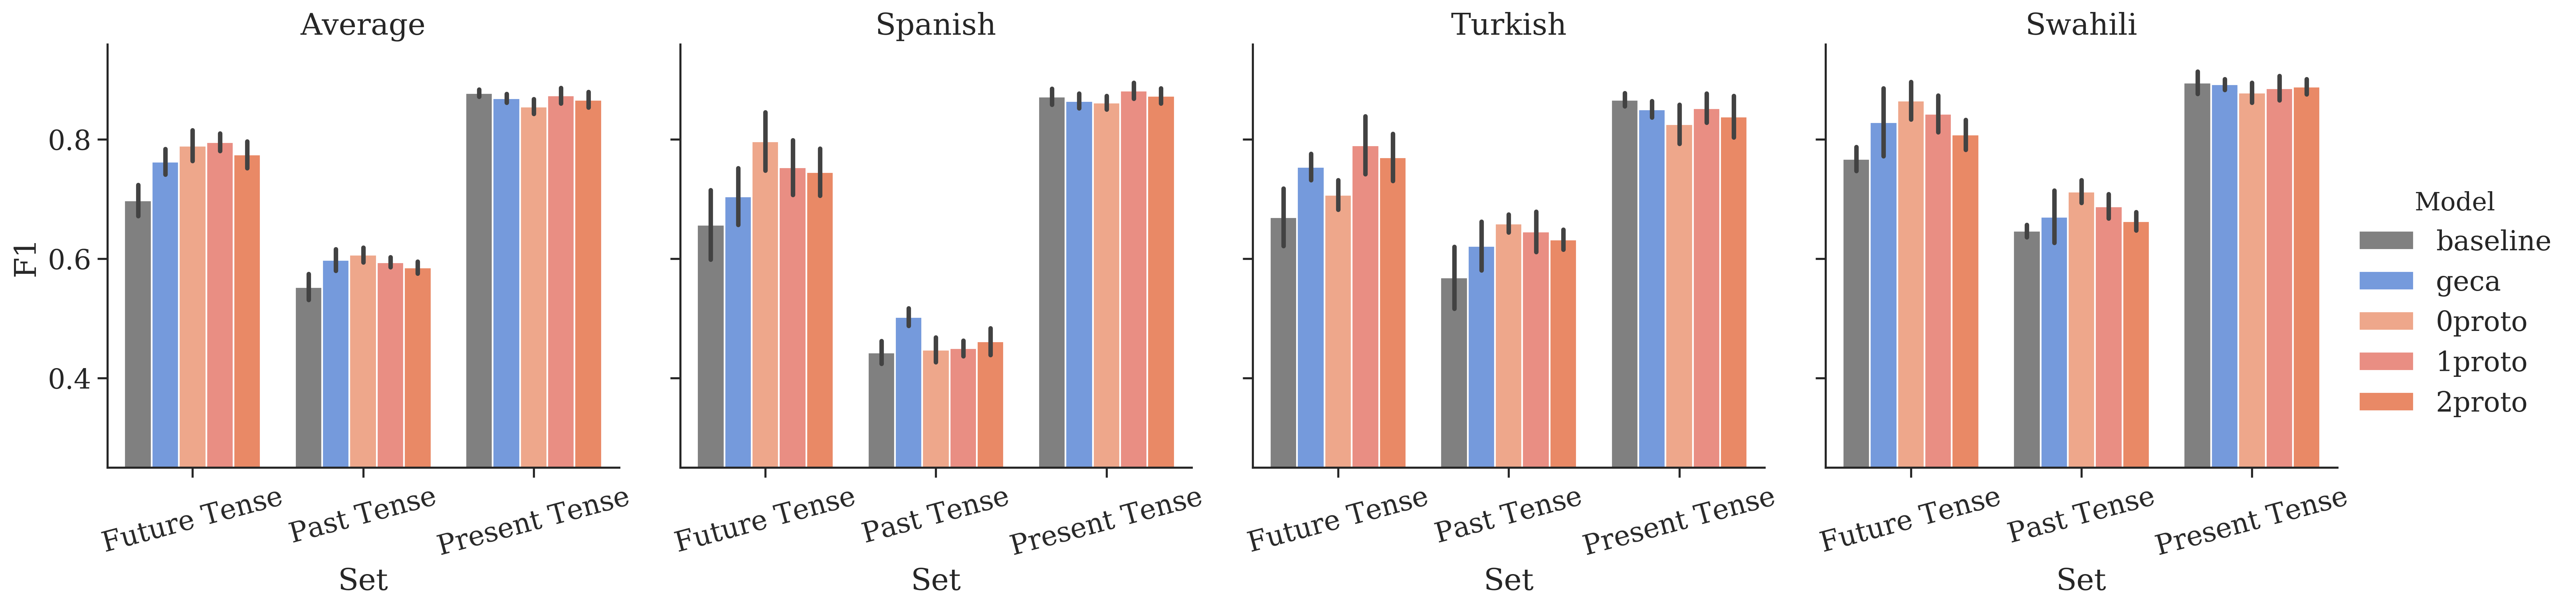

In [13]:
hints=4
vae="false"
g = get_morph_graph(hints=hints, vae=vae)
g.savefig("morph_results_hints_{}_vae_{}_{}.pdf".format(hints,vae,score), dpi=300, verbose=True)

##### Hints=4, VAE

225
75


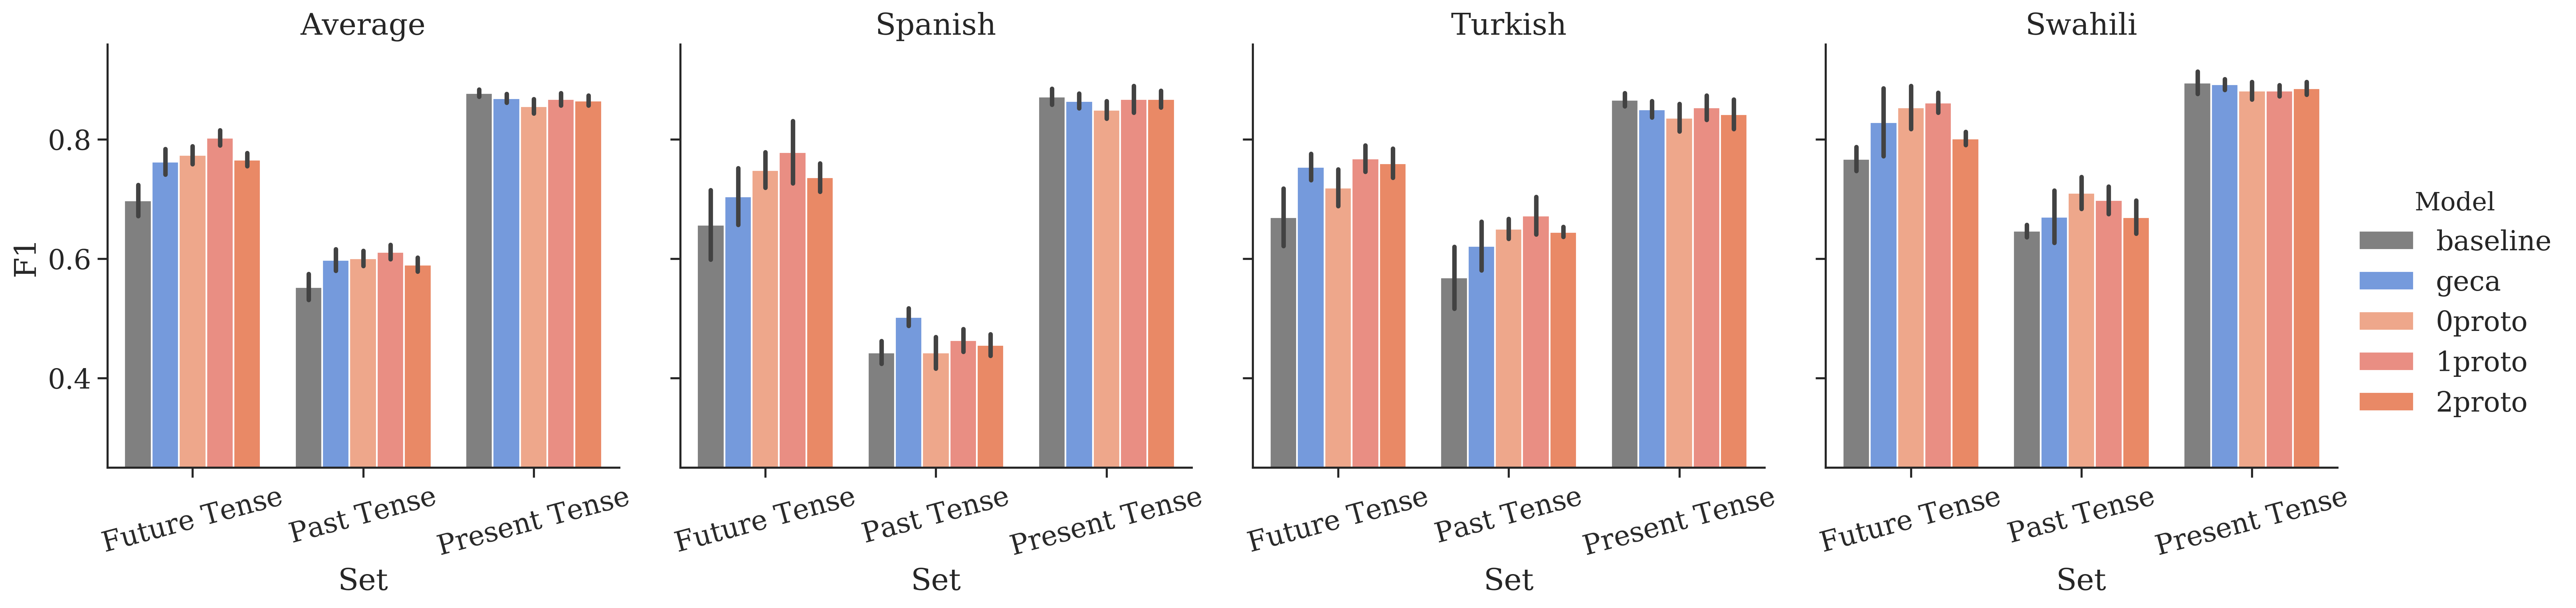

In [14]:
hints=4
vae="true"
g = get_morph_graph(hints=hints, vae=vae)
g.savefig("morph_results_hints_{}_vae_{}_{}.pdf".format(hints,vae,score), dpi=300, verbose=True)


##### Hints=8, NOVAE

225
75


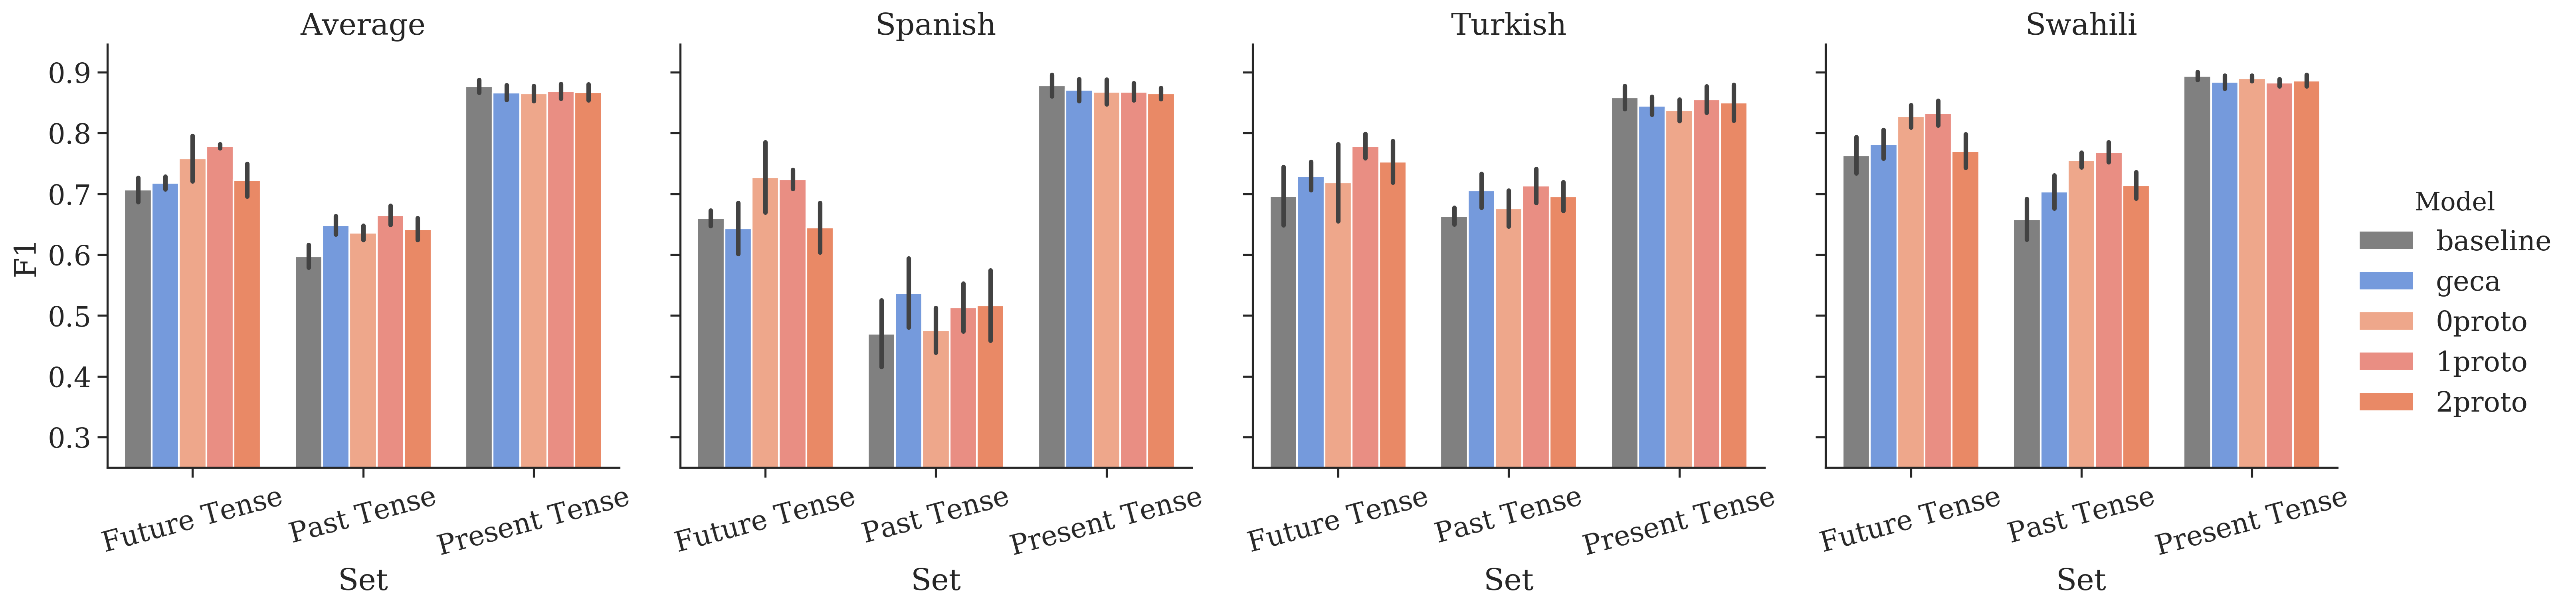

In [15]:
hints=8
vae="false"
g = get_morph_graph(hints=hints, vae=vae)
g.savefig("morph_results_hints_{}_vae_{}_{}.pdf".format(hints,vae,score), dpi=300, verbose=True)

##### Hints=8, VAE

225
75


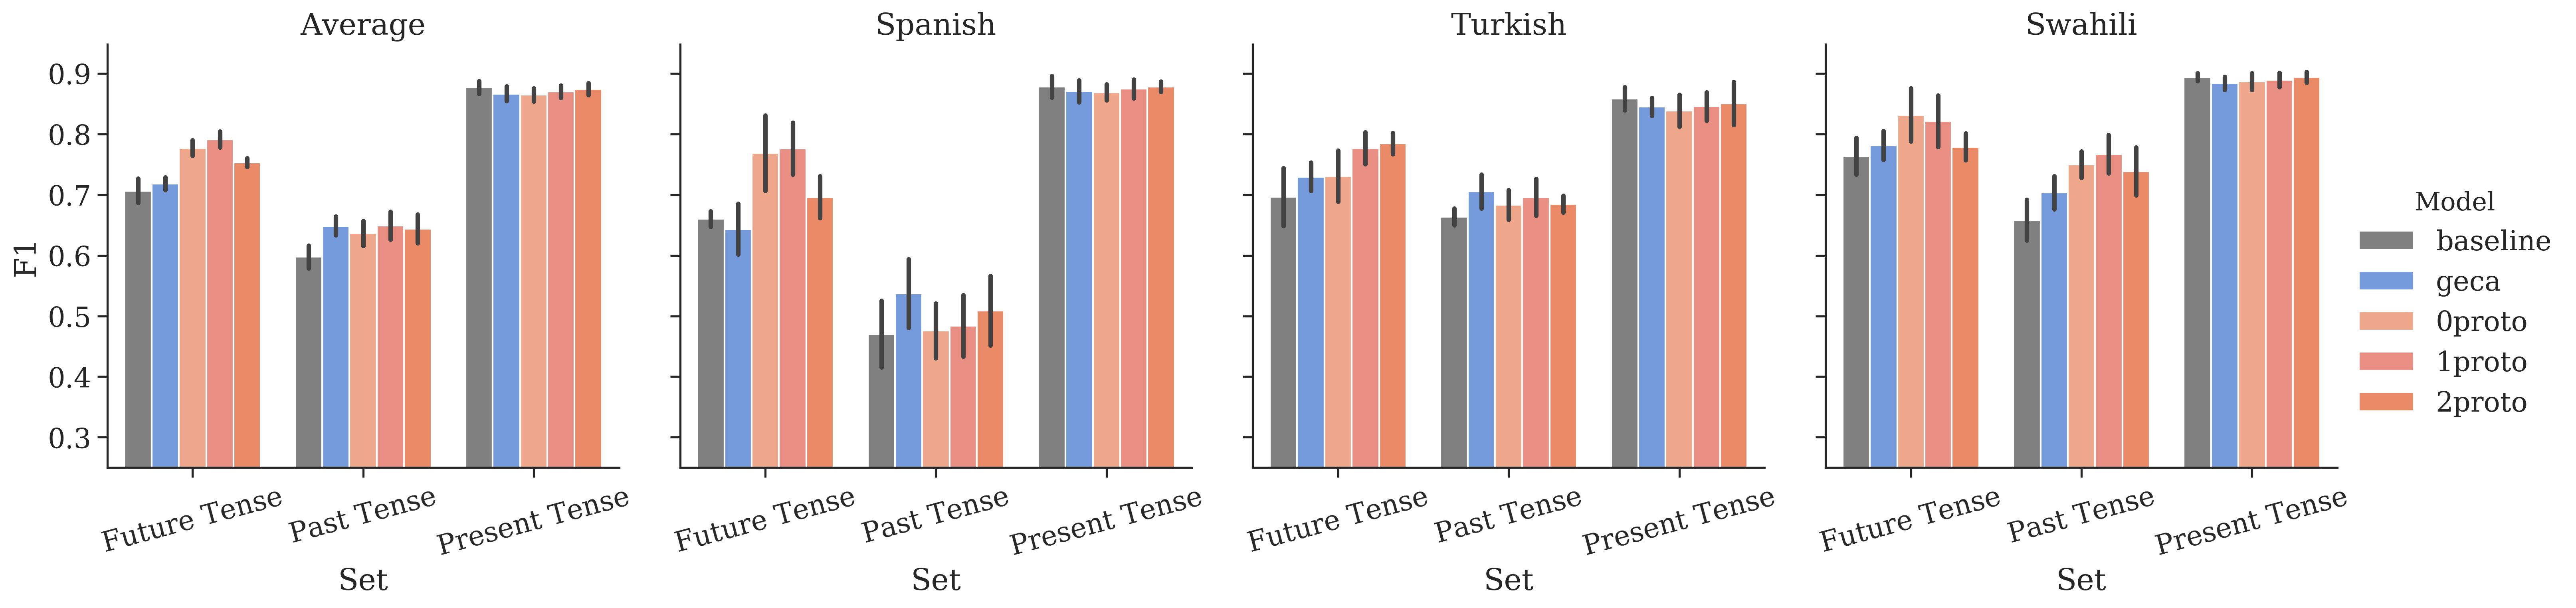

In [16]:
hints=8
vae="true"
g = get_morph_graph(hints=hints, vae=vae)
g.savefig("morph_results_hints_{}_vae_{}_{}.pdf".format(hints,vae,score), dpi=300, verbose=True)


#### Table

In [17]:
df

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,0.099499,0.595486,0.172985
1,spanish,4,0,true,baseline,VAL EVALS,0.03,0.170587,0.465753,0.201385
2,spanish,4,0,true,baseline,TEST EASY,0.64,0.480000,0.873440,0.191549
3,spanish,4,0,true,baseline,VAL EASY,0.61,0.487750,0.866667,0.201838
4,spanish,4,0,true,0proto,TEST EVALS,0.20,0.400000,0.719523,0.207692
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,0.495076,0.893037,0.161466
1796,swahili,16,4,false,geca,TEST EVALS,0.04,0.195959,0.746372,0.127119
1797,swahili,16,4,false,geca,VAL EVALS,0.12,0.324962,0.707844,0.228641
1798,swahili,16,4,false,geca,TEST EASY,0.51,0.499900,0.882096,0.167574


In [18]:
def mean_std(x):
    return(str(round(np.mean(x),2))+" (${+-}"+str(round(np.std(x),2))+"$)")

In [19]:
def my_mean(x):
    return(str(round(np.mean(x),2)))

In [20]:
def get_morph_results_table_alt_std(df, hints=4, vae="false", markdown=False):
    splits_s = ["TEST EVALS", "VAL EVALS", "TEST EASY"]
    splits_s_alt = ["Future Tense", "Past Tense", "Present Tense"]
    score_s = ["Acc", "F1"]
    cols_s = ["Language", "Seed", "Model", "Split"] + score_s

    df_filtered_s = df.replace(splits_s, splits_s_alt).\
                    loc[(df['Split'].isin(splits_s)) & (df['Vae'] == vae) & (df['Hints'] == hints), cols_s].\
                    reset_index().\
                    drop(columns=['index'])

    func = my_mean if markdown else mean_std
    print("Len: ", len(df_filtered_s))
    df_mean_std = df_filtered_s.groupby(by=["Model","Split", "Seed"]).\
                    agg({"Acc":"mean", "F1":"mean"}).\
                    reset_index().\
                    groupby(by=["Model","Split"]).\
                    agg({'Acc':func, 'F1':func}).\
                    reset_index("Split").pivot(columns="Split")

    df_mean_std.columns = df_mean_std.columns.swaplevel(1,0)
    return(df_mean_std.iloc[[3,4,0,1,2,],[0,3,1,4,2,5]])

##### Hints=4, NOVAE

In [21]:
df_mean_std = get_morph_results_table_alt_std(df)
display(df_mean_std)
print(df_mean_std.to_latex())

Len:  225


Split          Future Tense                            Past Tense  \
                        Acc                 F1                Acc   
Model                                                               
baseline  0.13 (${+-}0.05$)   0.7 (${+-}0.03$)  0.03 (${+-}0.02$)   
geca       0.24 (${+-}0.1$)  0.76 (${+-}0.02$)  0.07 (${+-}0.03$)   
0proto    0.36 (${+-}0.05$)  0.79 (${+-}0.03$)  0.06 (${+-}0.03$)   
1proto    0.31 (${+-}0.03$)   0.8 (${+-}0.01$)  0.05 (${+-}0.01$)   
2proto    0.19 (${+-}0.04$)  0.77 (${+-}0.02$)  0.03 (${+-}0.01$)   

Split                            Present Tense                     
                         F1                Acc                 F1  
Model                                                              
baseline  0.55 (${+-}0.02$)   0.6 (${+-}0.03$)  0.88 (${+-}0.01$)  
geca       0.6 (${+-}0.02$)  0.58 (${+-}0.03$)  0.87 (${+-}0.01$)  
0proto    0.61 (${+-}0.01$)  0.56 (${+-}0.03$)  0.85 (${+-}0.01$)  
1proto    0.59 (${+-}0.01$)  0.57 (${+-}0.04$)  0.87 (${+-}0.01$)  
2proto    0.59 (${+-}0.01$)  0.59 (${+-}0.03$)  0.87 (${+-}0.01$)

\begin{tabular}{lllllll}
\toprule
Split & \multicolumn{2}{l}{Future Tense} & \multicolumn{2}{l}{Past Tense} & \multicolumn{2}{l}{Present Tense} \\
{} &                Acc &                 F1 &                Acc &                 F1 &                Acc &                 F1 \\
Model    &                    &                    &                    &                    &                    &                    \\
\midrule
baseline &  0.13 (\$\{+-\}0.05\$) &   0.7 (\$\{+-\}0.03\$) &  0.03 (\$\{+-\}0.02\$) &  0.55 (\$\{+-\}0.02\$) &   0.6 (\$\{+-\}0.03\$) &  0.88 (\$\{+-\}0.01\$) \\
geca     &   0.24 (\$\{+-\}0.1\$) &  0.76 (\$\{+-\}0.02\$) &  0.07 (\$\{+-\}0.03\$) &   0.6 (\$\{+-\}0.02\$) &  0.58 (\$\{+-\}0.03\$) &  0.87 (\$\{+-\}0.01\$) \\
0proto   &  0.36 (\$\{+-\}0.05\$) &  0.79 (\$\{+-\}0.03\$) &  0.06 (\$\{+-\}0.03\$) &  0.61 (\$\{+-\}0.01\$) &  0.56 (\$\{+-\}0.03\$) &  0.85 (\$\{+-\}0.01\$) \\
1proto   &  0.31 (\$\{+-\}0.03\$) &   0.8 (\$\{+-\}0.01\$) &  0.05 (\$\{+-\}0.01\$) &  0

In [22]:
df_mean_std = get_morph_results_table_alt_std(df, hints=4, vae="true")
display(df_mean_std)
print(df_mean_std.to_latex())

Len:  225


Split          Future Tense                            Past Tense  \
                        Acc                 F1                Acc   
Model                                                               
baseline  0.13 (${+-}0.05$)   0.7 (${+-}0.03$)  0.03 (${+-}0.02$)   
geca       0.24 (${+-}0.1$)  0.76 (${+-}0.02$)  0.07 (${+-}0.03$)   
0proto     0.3 (${+-}0.06$)  0.77 (${+-}0.02$)  0.06 (${+-}0.03$)   
1proto    0.34 (${+-}0.05$)   0.8 (${+-}0.01$)  0.06 (${+-}0.01$)   
2proto    0.18 (${+-}0.02$)  0.77 (${+-}0.01$)  0.03 (${+-}0.01$)   

Split                            Present Tense                     
                         F1                Acc                 F1  
Model                                                              
baseline  0.55 (${+-}0.02$)   0.6 (${+-}0.03$)  0.88 (${+-}0.01$)  
geca       0.6 (${+-}0.02$)  0.58 (${+-}0.03$)  0.87 (${+-}0.01$)  
0proto     0.6 (${+-}0.01$)  0.54 (${+-}0.03$)  0.86 (${+-}0.01$)  
1proto    0.61 (${+-}0.01$)  0.57 (${+-}0.04$)  0.87 (${+-}0.01$)  
2proto    0.59 (${+-}0.01$)  0.57 (${+-}0.03$)  0.86 (${+-}0.01$)

\begin{tabular}{lllllll}
\toprule
Split & \multicolumn{2}{l}{Future Tense} & \multicolumn{2}{l}{Past Tense} & \multicolumn{2}{l}{Present Tense} \\
{} &                Acc &                 F1 &                Acc &                 F1 &                Acc &                 F1 \\
Model    &                    &                    &                    &                    &                    &                    \\
\midrule
baseline &  0.13 (\$\{+-\}0.05\$) &   0.7 (\$\{+-\}0.03\$) &  0.03 (\$\{+-\}0.02\$) &  0.55 (\$\{+-\}0.02\$) &   0.6 (\$\{+-\}0.03\$) &  0.88 (\$\{+-\}0.01\$) \\
geca     &   0.24 (\$\{+-\}0.1\$) &  0.76 (\$\{+-\}0.02\$) &  0.07 (\$\{+-\}0.03\$) &   0.6 (\$\{+-\}0.02\$) &  0.58 (\$\{+-\}0.03\$) &  0.87 (\$\{+-\}0.01\$) \\
0proto   &   0.3 (\$\{+-\}0.06\$) &  0.77 (\$\{+-\}0.02\$) &  0.06 (\$\{+-\}0.03\$) &   0.6 (\$\{+-\}0.01\$) &  0.54 (\$\{+-\}0.03\$) &  0.86 (\$\{+-\}0.01\$) \\
1proto   &  0.34 (\$\{+-\}0.05\$) &   0.8 (\$\{+-\}0.01\$) &  0.06 (\$\{+-\}0.01\$) &  0

In [23]:
df_mean_std = get_morph_results_table_alt_std(df, hints=8, vae="false")
display(df_mean_std)
print(df_mean_std.to_latex())

Len:  225


Split          Future Tense                            Past Tense  \
                        Acc                 F1                Acc   
Model                                                               
baseline  0.11 (${+-}0.01$)  0.71 (${+-}0.02$)  0.07 (${+-}0.03$)   
geca      0.13 (${+-}0.01$)  0.72 (${+-}0.01$)  0.13 (${+-}0.01$)   
0proto    0.27 (${+-}0.07$)  0.76 (${+-}0.04$)   0.1 (${+-}0.02$)   
1proto    0.24 (${+-}0.03$)   0.78 (${+-}0.0$)  0.12 (${+-}0.02$)   
2proto    0.15 (${+-}0.03$)  0.72 (${+-}0.03$)  0.11 (${+-}0.02$)   

Split                            Present Tense                     
                         F1                Acc                 F1  
Model                                                              
baseline   0.6 (${+-}0.02$)  0.59 (${+-}0.02$)  0.88 (${+-}0.01$)  
geca      0.65 (${+-}0.02$)  0.57 (${+-}0.02$)  0.87 (${+-}0.01$)  
0proto    0.64 (${+-}0.01$)  0.56 (${+-}0.03$)  0.86 (${+-}0.01$)  
1proto    0.67 (${+-}0.02$)  0.57 (${+-}0.03$)  0.87 (${+-}0.01$)  
2proto    0.64 (${+-}0.02$)  0.57 (${+-}0.02$)  0.87 (${+-}0.01$)

\begin{tabular}{lllllll}
\toprule
Split & \multicolumn{2}{l}{Future Tense} & \multicolumn{2}{l}{Past Tense} & \multicolumn{2}{l}{Present Tense} \\
{} &                Acc &                 F1 &                Acc &                 F1 &                Acc &                 F1 \\
Model    &                    &                    &                    &                    &                    &                    \\
\midrule
baseline &  0.11 (\$\{+-\}0.01\$) &  0.71 (\$\{+-\}0.02\$) &  0.07 (\$\{+-\}0.03\$) &   0.6 (\$\{+-\}0.02\$) &  0.59 (\$\{+-\}0.02\$) &  0.88 (\$\{+-\}0.01\$) \\
geca     &  0.13 (\$\{+-\}0.01\$) &  0.72 (\$\{+-\}0.01\$) &  0.13 (\$\{+-\}0.01\$) &  0.65 (\$\{+-\}0.02\$) &  0.57 (\$\{+-\}0.02\$) &  0.87 (\$\{+-\}0.01\$) \\
0proto   &  0.27 (\$\{+-\}0.07\$) &  0.76 (\$\{+-\}0.04\$) &   0.1 (\$\{+-\}0.02\$) &  0.64 (\$\{+-\}0.01\$) &  0.56 (\$\{+-\}0.03\$) &  0.86 (\$\{+-\}0.01\$) \\
1proto   &  0.24 (\$\{+-\}0.03\$) &   0.78 (\$\{+-\}0.0\$) &  0.12 (\$\{+-\}0.02\$) &  0

In [24]:
df_mean_std = get_morph_results_table_alt_std(df, hints=8, vae="true")
display(df_mean_std)
print(df_mean_std.to_latex())

Len:  225


Split          Future Tense                            Past Tense  \
                        Acc                 F1                Acc   
Model                                                               
baseline  0.11 (${+-}0.01$)  0.71 (${+-}0.02$)  0.07 (${+-}0.03$)   
geca      0.13 (${+-}0.01$)  0.72 (${+-}0.01$)  0.13 (${+-}0.01$)   
0proto    0.32 (${+-}0.04$)  0.78 (${+-}0.01$)  0.09 (${+-}0.01$)   
1proto    0.29 (${+-}0.05$)  0.79 (${+-}0.01$)  0.11 (${+-}0.03$)   
2proto    0.15 (${+-}0.02$)  0.75 (${+-}0.01$)   0.1 (${+-}0.02$)   

Split                            Present Tense                     
                         F1                Acc                 F1  
Model                                                              
baseline   0.6 (${+-}0.02$)  0.59 (${+-}0.02$)  0.88 (${+-}0.01$)  
geca      0.65 (${+-}0.02$)  0.57 (${+-}0.02$)  0.87 (${+-}0.01$)  
0proto    0.64 (${+-}0.02$)  0.55 (${+-}0.03$)  0.86 (${+-}0.01$)  
1proto    0.65 (${+-}0.02$)  0.57 (${+-}0.02$)  0.87 (${+-}0.01$)  
2proto    0.64 (${+-}0.02$)  0.59 (${+-}0.02$)  0.87 (${+-}0.01$)

\begin{tabular}{lllllll}
\toprule
Split & \multicolumn{2}{l}{Future Tense} & \multicolumn{2}{l}{Past Tense} & \multicolumn{2}{l}{Present Tense} \\
{} &                Acc &                 F1 &                Acc &                 F1 &                Acc &                 F1 \\
Model    &                    &                    &                    &                    &                    &                    \\
\midrule
baseline &  0.11 (\$\{+-\}0.01\$) &  0.71 (\$\{+-\}0.02\$) &  0.07 (\$\{+-\}0.03\$) &   0.6 (\$\{+-\}0.02\$) &  0.59 (\$\{+-\}0.02\$) &  0.88 (\$\{+-\}0.01\$) \\
geca     &  0.13 (\$\{+-\}0.01\$) &  0.72 (\$\{+-\}0.01\$) &  0.13 (\$\{+-\}0.01\$) &  0.65 (\$\{+-\}0.02\$) &  0.57 (\$\{+-\}0.02\$) &  0.87 (\$\{+-\}0.01\$) \\
0proto   &  0.32 (\$\{+-\}0.04\$) &  0.78 (\$\{+-\}0.01\$) &  0.09 (\$\{+-\}0.01\$) &  0.64 (\$\{+-\}0.02\$) &  0.55 (\$\{+-\}0.03\$) &  0.86 (\$\{+-\}0.01\$) \\
1proto   &  0.29 (\$\{+-\}0.05\$) &  0.79 (\$\{+-\}0.01\$) &  0.11 (\$\{+-\}0.03\$) &  0

In [25]:
# same table as the paper this time for markdown
df_mean_std = get_morph_results_table_alt_std(df, hints=4, vae="false", markdown=True)
display(df_mean_std)
print(df_mean_std.to_markdown())

Len:  225


Split    Future Tense       Past Tense       Present Tense      
                  Acc    F1        Acc    F1           Acc    F1
Model                                                           
baseline         0.13   0.7       0.03  0.55           0.6  0.88
geca             0.24  0.76       0.07   0.6          0.58  0.87
0proto           0.36  0.79       0.06  0.61          0.56  0.85
1proto           0.31   0.8       0.05  0.59          0.57  0.87
2proto           0.19  0.77       0.03  0.59          0.59  0.87

| Model    |   ('Future Tense', 'Acc') |   ('Future Tense', 'F1') |   ('Past Tense', 'Acc') |   ('Past Tense', 'F1') |   ('Present Tense', 'Acc') |   ('Present Tense', 'F1') |
|:---------|--------------------------:|-------------------------:|------------------------:|-----------------------:|---------------------------:|--------------------------:|
| baseline |                      0.13 |                     0.7  |                    0.03 |                   0.55 |                       0.6  |                      0.88 |
| geca     |                      0.24 |                     0.76 |                    0.07 |                   0.6  |                       0.58 |                      0.87 |
| 0proto   |                      0.36 |                     0.79 |                    0.06 |                   0.61 |                       0.56 |                      0.85 |
| 1proto   |                      0.31 |                     0.8  |                    0.05 |                   0.59 |  

### SCAN Results Graph

In [26]:
def get_scan_scores(df=None,
                    tasks=("jump","around_right"),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("0proto","1proto","2proto"),
                    exppath="./checkpoints",
                   ):
    for task in tasks:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        taskpath=os.path.join(exppath,"SCANDataSet")
                        identifier ="{}.vae.{}.{}.seed.{}".format(model,vae,task,seed)
                        condfile=os.path.join(taskpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():
                                acc, accstd, f1, f1std = calculate_scores(lines[r])  
                                df.loc[len(df.index)] = (task,s,seed,vae,model,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

In [27]:
#create SCAN table
dfscan = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan)
dfscan_other = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan_other,
                models=("2proto",),
                tasks=("jump",),
                exppath="./checkpoints_dgx_scan/",
               )
# results with seed 5-9
dfscan_other['Seed'] = dfscan_other['Seed'] + 5
dfscan_all=dfscan.append(dfscan_other, ignore_index=True)
dfscan_all

processing: ./checkpoints/SCANDataSet/logs/0proto.vae.true.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/1proto.vae.true.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/2proto.vae.true.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/0proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/1proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/2proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints/SCANDataSet/logs/0proto.vae.true.jump.seed.1.cond.log
processing: ./checkpoints/SCANDataSet/logs/1proto.vae.true.jump.seed.1.cond.log
processing: ./checkpoints/SCANDataSet/logs/2proto.vae.true.jump.seed.1.cond.log
processing: ./checkpoints/SCANDataSet/logs/0proto.vae.false.jump.seed.1.cond.log
processing: ./checkpoints/SCANDataSet/logs/1proto.vae.false.jump.seed.1.cond.log
processing: ./checkpoints/SCANDataSet/logs/2proto.vae.false.jump.seed.1.cond.log
processing: ./checkpoints/SCANData

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
0,jump,TEST EVALS,0,true,0proto,0.000000,0.000000,0.756223,0.154850
1,jump,VAL EVALS,0,true,0proto,0.998485,0.038895,1.000000,0.000000
2,jump,TEST EVALS,0,true,1proto,0.014794,0.120726,0.753597,0.159557
3,jump,VAL EVALS,0,true,1proto,1.000000,0.000000,1.000000,0.000000
4,jump,TEST EVALS,0,true,2proto,0.987412,0.111486,0.998560,0.045034
...,...,...,...,...,...,...,...,...,...
135,jump,VAL EVALS,8,false,2proto,0.986364,0.115976,1.000000,0.000000
136,jump,TEST EVALS,9,true,2proto,0.810797,0.391670,0.980174,0.053297
137,jump,VAL EVALS,9,true,2proto,1.000000,0.000000,1.000000,0.000000
138,jump,TEST EVALS,9,false,2proto,0.744355,0.436223,0.940522,0.119155


In [28]:
dfscan_all

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
0,jump,TEST EVALS,0,true,0proto,0.000000,0.000000,0.756223,0.154850
1,jump,VAL EVALS,0,true,0proto,0.998485,0.038895,1.000000,0.000000
2,jump,TEST EVALS,0,true,1proto,0.014794,0.120726,0.753597,0.159557
3,jump,VAL EVALS,0,true,1proto,1.000000,0.000000,1.000000,0.000000
4,jump,TEST EVALS,0,true,2proto,0.987412,0.111486,0.998560,0.045034
...,...,...,...,...,...,...,...,...,...
135,jump,VAL EVALS,8,false,2proto,0.986364,0.115976,1.000000,0.000000
136,jump,TEST EVALS,9,true,2proto,0.810797,0.391670,0.980174,0.053297
137,jump,VAL EVALS,9,true,2proto,1.000000,0.000000,1.000000,0.000000
138,jump,TEST EVALS,9,false,2proto,0.744355,0.436223,0.940522,0.119155


In [29]:
def get_scan_results_table(dfscan_all, markdown=False):
    splits_s = ["TEST EVALS"]
    score_s = "Acc"
    cols_s = ["Task", "Seed", "Model", "Split", score_s]
    vae_s = "false"
    
    df_filtered_s = dfscan_all.loc[(dfscan_all['Split'].isin(splits_s)) & (dfscan_all['Vae'] == vae_s), cols_s].\
                    reset_index().\
                    drop(columns=['index', 'Split'])
                    
    df_filtered_s.head()
    print("Len: ", len(df_filtered_s))
    
    # add geca and baseline scores
    geca_baseline_s = pd.read_csv("stats/scan-geca-baseline.csv", header=None)
    print("Total of {} GECA and baseline records.".format(len(geca_baseline_s)))
    
    # append
    for index,row in geca_baseline_s.iterrows():
    
        task = row[0]
        seed = row[1]
        model = row[2]
        val = float(row[3])

        df_filtered_s.loc[len(df_filtered_s)] = [task, seed, model, val]
    
    func = my_mean if markdown else mean_std
    dfscan_mean_std = df_filtered_s.groupby(by=["Model","Task"]).\
                    agg({"Acc":func}).\
                    reset_index("Task").\
                    pivot(columns="Task").\
                    rename(columns={"around_right":"AROUND RIGHT", "jump":"JUMP"})

    return(dfscan_mean_std.iloc[:,:])



In [30]:
dfscan_mean_std = get_scan_results_table(dfscan_all)
display(dfscan_mean_std)
print(dfscan_mean_std.to_latex())

Len:  35
Total of 39 GECA and baseline records.


Acc                   
Task            AROUND RIGHT               JUMP
Model                                          
 baseline    0.0 (${+-}0.0$)    0.0 (${+-}0.0$)
 geca      0.82 (${+-}0.11$)  0.87 (${+-}0.05$)
0proto       0.0 (${+-}0.0$)    0.0 (${+-}0.0$)
1proto     0.16 (${+-}0.04$)    0.0 (${+-}0.0$)
2proto     0.51 (${+-}0.07$)  0.88 (${+-}0.08$)

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{Acc} \\
Task &       AROUND RIGHT &               JUMP \\
Model     &                    &                    \\
\midrule
 baseline &    0.0 (\$\{+-\}0.0\$) &    0.0 (\$\{+-\}0.0\$) \\
 geca     &  0.82 (\$\{+-\}0.11\$) &  0.87 (\$\{+-\}0.05\$) \\
0proto    &    0.0 (\$\{+-\}0.0\$) &    0.0 (\$\{+-\}0.0\$) \\
1proto    &  0.16 (\$\{+-\}0.04\$) &    0.0 (\$\{+-\}0.0\$) \\
2proto    &  0.51 (\$\{+-\}0.07\$) &  0.88 (\$\{+-\}0.08\$) \\
\bottomrule
\end{tabular}



In [31]:
# markdown
dfscan_mean_std = get_scan_results_table(dfscan_all, markdown=True)
print(dfscan_mean_std.to_markdown())

Len:  35
Total of 39 GECA and baseline records.
| Model    |   ('Acc', 'AROUND RIGHT') |   ('Acc', 'JUMP') |
|:---------|--------------------------:|------------------:|
| baseline |                      0    |              0    |
| geca     |                      0.82 |              0.87 |
| 0proto   |                      0    |              0    |
| 1proto   |                      0.16 |              0    |
| 2proto   |                      0.51 |              0.88 |


In [32]:
def get_lang_scores_unreduced(df=None,
                    langs=("spanish","turkish","swahili"),
                    hintss=(4,8,16),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("baseline","0proto","1proto","2proto"),
                    exppath="./checkpoints",
                   ):
    for lang in langs:
        for hints in hintss:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        langpath=os.path.join(exppath,"SIGDataSet",lang)
                        if model == "baseline" or model == "geca":
                            identifier ="{}.hints.{}.seed.{}".format(model,hints,seed)
                        else:
                            identifier ="{}.vae.{}.hints.{}.seed.{}".format(model,vae,hints,seed)
                        condfile=os.path.join(langpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            if len(lines) < 2142:
                                print("format broken in "+condfile)
                                continue
#                             print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():#splitinfo.items():
                                acc, accstd, f1, f1std = calculate_scores_unreduced(lines[r])  
                                df.loc[len(df.index)] = (lang,hints,seed,vae,model,s,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

In [33]:
dfunreduced = pd.DataFrame(columns=('Language', 'Hints', 'Seed', 'Vae','Model','Split','Acc','Acc_std','F1','F1_std',))
get_lang_scores_unreduced(df=dfunreduced,exppath="./checkpoints")
get_lang_scores_unreduced(df=dfunreduced,exppath="./checkpoints_gecaexp",
                models=("geca",))
dfunreduced

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,"[False, False, False, False, False, False, Fal...",0.595486,"[0.8333333333333334, 0.7272727272727272, 0.333..."
1,spanish,4,0,true,baseline,VAL EVALS,0.03,"[False, False, False, False, False, False, Fal...",0.465753,"[0.4615384615384615, 0.30769230769230765, 0.83..."
2,spanish,4,0,true,baseline,TEST EASY,0.64,"[False, False, True, False, True, False, False...",0.873440,"[0.8333333333333334, 0.8333333333333334, 1.0, ..."
3,spanish,4,0,true,baseline,VAL EASY,0.61,"[False, True, False, False, True, False, True,...",0.866667,"[0.8333333333333334, 1.0, 0.3333333333333333, ..."
4,spanish,4,0,true,0proto,TEST EVALS,0.20,"[False, False, False, False, False, False, Fal...",0.719523,"[0.6666666666666666, 0.8333333333333334, 0.833..."
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,"[True, False, False, True, True, False, True, ...",0.893037,"[1.0, 0.75, 0.6153846153846153, 1.0, 1.0, 0.70..."
1796,swahili,16,4,false,geca,TEST EVALS,0.04,"[False, False, False, False, False, False, Fal...",0.746372,"[0.7142857142857143, 0.8571428571428571, 0.666..."
1797,swahili,16,4,false,geca,VAL EVALS,0.12,"[True, True, False, False, False, False, True,...",0.707844,"[1.0, 1.0, 0.6250000000000001, 0.8888888888888..."
1798,swahili,16,4,false,geca,TEST EASY,0.51,"[True, True, False, False, True, False, False,...",0.882096,"[1.0, 1.0, 0.875, 0.875, 1.0, 0.83333333333333..."


In [34]:
dfunreduced.head()

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,"[False, False, False, False, False, False, Fal...",0.595486,"[0.8333333333333334, 0.7272727272727272, 0.333..."
1,spanish,4,0,true,baseline,VAL EVALS,0.03,"[False, False, False, False, False, False, Fal...",0.465753,"[0.4615384615384615, 0.30769230769230765, 0.83..."
2,spanish,4,0,true,baseline,TEST EASY,0.64,"[False, False, True, False, True, False, False...",0.873440,"[0.8333333333333334, 0.8333333333333334, 1.0, ..."
3,spanish,4,0,true,baseline,VAL EASY,0.61,"[False, True, False, False, True, False, True,...",0.866667,"[0.8333333333333334, 1.0, 0.3333333333333333, ..."
4,spanish,4,0,true,0proto,TEST EVALS,0.20,"[False, False, False, False, False, False, Fal...",0.719523,"[0.6666666666666666, 0.8333333333333334, 0.833..."


In [35]:
d = {}
models=("baseline","geca","0proto","1proto","2proto")
langs = ("spanish", "turkish", "swahili")
hints=4
vae="false"
split="TEST EVALS"
cols = ["Language", "Seed", "Model", "Acc_std", "F1_std"]
conds = (dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae) & (dfunreduced["Split"]==split)
dfunreduced_filtered = dfunreduced.loc[conds, cols]


In [36]:
dfunreduced_filtered

,Language,Seed,Model,Acc_std,F1_std
16,spanish,0,baseline,"[False, False, False, False, False, False, Fal...","[0.8333333333333334, 0.7272727272727272, 0.333..."
20,spanish,0,0proto,"[True, False, False, False, False, True, True,...","[1.0, 0.8333333333333334, 0.5, 0.5, 0.66666666..."
24,spanish,0,1proto,"[False, False, False, False, False, False, Tru...","[0.4615384615384615, 0.8333333333333334, 0.833..."
28,spanish,0,2proto,"[False, False, True, False, False, False, Fals...","[0.4615384615384615, 0.6153846153846153, 1.0, ..."
48,spanish,1,baseline,"[False, False, False, False, False, False, Fal...","[0.5, 0.3333333333333333, 0.8333333333333334, ..."
...,...,...,...,...,...
1684,swahili,0,geca,"[False, False, False, False, False, True, Fals...","[0.7142857142857143, 0.8571428571428571, 0.714..."
1692,swahili,1,geca,"[True, True, True, False, False, True, True, T...","[1.0, 1.0, 1.0, 0.7142857142857143, 0.66666666..."
1700,swahili,2,geca,"[False, True, True, False, True, False, True, ...","[0.6666666666666666, 1.0, 1.0, 0.8571428571428..."
1708,swahili,3,geca,"[False, False, False, False, True, True, False...","[0.7692307692307692, 0.8571428571428571, 0.666..."


In [37]:
for m in models:
    d[m] = {}
    for t in ["Acc_std", "F1_std"]:
        d[m][t] = []
        for l in langs:
            for s in range(5):
                cond1 = (dfunreduced_filtered["Model"]==m) & (dfunreduced_filtered["Language"]==l)
                cond2 = (dfunreduced_filtered["Seed"]==s)
#                 pdb.set_trace()
                if t == "Acc_std":
                    d[m][t].extend([int(el) for el in dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0]])
                else:
                    d[m][t].extend(dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0])
#         d[m][t].update({t:ls})

In [38]:
len(d["baseline"]["Acc_std"])

1500

In [39]:
sum(d["baseline"]["Acc_std"])

200

In [40]:
sum(d["0proto"]["Acc_std"])

539

In [41]:
d_avg = {}
for m in models:
    d_avg[m] = {}
    for t in ["Acc_std", "F1_std"]:
#         d_avg[m][t] = {}
        d_avg[m][t] = np.mean(d[m][t])
#         d_avg[m][t]["std"] = np.std(d[m][t])

In [42]:
pd.DataFrame(d_avg)

,baseline,geca,0proto,1proto,2proto
Acc_std,0.133333,0.243333,0.359333,0.311333,0.192667
F1_std,0.692341,0.758732,0.780631,0.792064,0.771988


In [43]:
from scipy import stats

In [44]:
def t_test(model1, model2, t):
    return(stats.ttest_rel(d[model1][t],d[model2][t]).pvalue)

def get_pvals(t):
    sign = {}
    for m1 in models:
        sign[m1] = {}
        for m2 in models:
            sign[m1][m2] = t_test(m1,m2,t)
    return(pd.DataFrame(sign))
print("acc")       
display(get_pvals("Acc_std"))
print("f1")
display(get_pvals("F1_std"))

acc


,baseline,geca,0proto,1proto,2proto
baseline,NaN,1.550081e-15,1.600765e-48,3.591011e-32,7.481700e-06
geca,1.550081e-15,NaN,4.923557e-12,2.249231e-05,6.483285e-04
0proto,1.600765e-48,4.923557e-12,NaN,5.167716e-03,3.006737e-24
1proto,3.591011e-32,2.249231e-05,5.167716e-03,NaN,6.600711e-14
2proto,7.481700e-06,6.483285e-04,3.006737e-24,6.600711e-14,NaN


f1


,baseline,geca,0proto,1proto,2proto
baseline,NaN,7.566961e-16,1.506069e-21,3.785714e-32,2.232144e-23
geca,7.566961e-16,NaN,1.315362e-02,1.876577e-05,7.638536e-02
0proto,1.506069e-21,1.315362e-02,NaN,1.893049e-01,2.970492e-01
1proto,3.785714e-32,1.876577e-05,1.893049e-01,NaN,6.946424e-03
2proto,2.232144e-23,7.638536e-02,2.970492e-01,6.946424e-03,NaN


In [45]:
# bonferroni correction
f1pvalsfut = 10*get_pvals("F1_std")
print(f1pvalsfut.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      baseline &          geca &        0proto &        1proto &        2proto \\
\midrule
baseline &           NaN &  7.566961e-15 &  1.506069e-20 &  3.785714e-31 &  2.232144e-22 \\
geca     &  7.566961e-15 &           NaN &  1.315362e-01 &  1.876577e-04 &  7.638536e-01 \\
0proto   &  1.506069e-20 &  1.315362e-01 &           NaN &  1.893049e+00 &  2.970492e+00 \\
1proto   &  3.785714e-31 &  1.876577e-04 &  1.893049e+00 &           NaN &  6.946424e-02 \\
2proto   &  2.232144e-22 &  7.638536e-01 &  2.970492e+00 &  6.946424e-02 &           NaN \\
\bottomrule
\end{tabular}



In [46]:
d = {}
models=("baseline","geca","0proto","1proto","2proto")
langs = ("spanish", "turkish", "swahili")
hints=4
vae="false"
split="VAL EVALS"
cols = ["Language", "Seed", "Model", "Acc_std", "F1_std"]
conds = (dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae) & (dfunreduced["Split"]==split)
dfunreduced_filtered = dfunreduced.loc[conds, cols]

for m in models:
    d[m] = {}
    for t in ["Acc_std", "F1_std"]:
        d[m][t] = []
        for l in langs:
            for s in range(5):
                cond1 = (dfunreduced_filtered["Model"]==m) & (dfunreduced_filtered["Language"]==l)
                cond2 = (dfunreduced_filtered["Seed"]==s)
#                 pdb.set_trace()
                if t == "Acc_std":
                    d[m][t].extend([int(el) for el in dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0]])
                else:
                    d[m][t].extend(dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0])
                    
                    
d_avg = {}
for m in models:
    d_avg[m] = {}
    for t in ["Acc_std", "F1_std"]:
#         d_avg[m][t] = {}
        d_avg[m][t] = np.mean(d[m][t])
#         d_avg[m][t]["std"] = np.std(d[m][t])

f1pvalspst = get_pvals("F1_std")
print(f1pvalspst.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      baseline &      geca &        0proto &    1proto &    2proto \\
\midrule
baseline &           NaN &  0.000002 &  4.069992e-09 &  0.000003 &  0.000181 \\
geca     &  2.224818e-06 &       NaN &  3.252890e-01 &  0.850648 &  0.241721 \\
0proto   &  4.069992e-09 &  0.325289 &           NaN &  0.207379 &  0.021882 \\
1proto   &  3.492314e-06 &  0.850648 &  2.073788e-01 &       NaN &  0.288306 \\
2proto   &  1.806165e-04 &  0.241721 &  2.188150e-02 &  0.288306 &       NaN \\
\bottomrule
\end{tabular}



In [47]:
# bonferroni correction
f1pvalspst = 10*get_pvals("F1_std")
print(f1pvalspst.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      baseline &      geca &        0proto &    1proto &    2proto \\
\midrule
baseline &           NaN &  0.000022 &  4.069992e-08 &  0.000035 &  0.001806 \\
geca     &  2.224818e-05 &       NaN &  3.252890e+00 &  8.506484 &  2.417210 \\
0proto   &  4.069992e-08 &  3.252890 &           NaN &  2.073788 &  0.218815 \\
1proto   &  3.492314e-05 &  8.506484 &  2.073788e+00 &       NaN &  2.883061 \\
2proto   &  1.806165e-03 &  2.417210 &  2.188150e-01 &  2.883061 &       NaN \\
\bottomrule
\end{tabular}



In [48]:
def get_scan_scores_unreduced(df=None,
                    tasks=("jump","around_right"),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("0proto","1proto","2proto"),
                    exppath="./checkpoints",
                   ):
    for task in tasks:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        taskpath=os.path.join(exppath,"SCANDataSet")
                        identifier ="{}.vae.{}.{}.seed.{}".format(model,vae,task,seed)
                        condfile=os.path.join(taskpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():
                                acc, accstd, f1, f1std = calculate_scores_unreduced(lines[r])  
                                df.loc[len(df.index)] = (task,s,seed,vae,model,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

#### Ablations

In [49]:
dfscan_ablations = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan_ablations,
                models=("ID.1proto","nocopy.1proto", "nocopy.2proto"),
                exppath="./checkpoints_ablations/",
               )

processing: ./checkpoints_ablations/SCANDataSet/logs/ID.1proto.vae.true.jump.seed.0.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/nocopy.1proto.vae.true.jump.seed.0.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/nocopy.2proto.vae.true.jump.seed.0.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/ID.1proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints_ablations/SCANDataSet/logs/nocopy.1proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints_ablations/SCANDataSet/logs/nocopy.2proto.vae.false.jump.seed.0.cond.log
processing: ./checkpoints_ablations/SCANDataSet/logs/ID.1proto.vae.true.jump.seed.1.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/nocopy.1proto.vae.true.jump.seed.1.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/nocopy.2proto.vae.true.jump.seed.1.cond.log
file doesnot exist: ./checkpoints_ablations/SCANDataSet/logs/ID.1proto.vae.false.jump.seed.1.con

In [50]:
dfscan_ablations[(dfscan_ablations["Split"]=="TEST EVALS") & (dfscan_ablations["Task"]=="around_right")]

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
12,around_right,TEST EVALS,0,true,ID.1proto,0.125559,0.331351,0.992651,0.038756
14,around_right,TEST EVALS,0,true,nocopy.1proto,0.000000,0.000000,0.929009,0.087060
16,around_right,TEST EVALS,0,false,nocopy.1proto,0.033289,0.179389,0.928920,0.086338
18,around_right,TEST EVALS,0,false,nocopy.2proto,0.000000,0.000000,0.889319,0.121090
20,around_right,TEST EVALS,1,true,ID.1proto,0.152368,0.359377,0.984043,0.047892
22,around_right,TEST EVALS,1,true,nocopy.1proto,0.012288,0.110167,0.940403,0.091401
24,around_right,TEST EVALS,1,false,nocopy.1proto,0.000000,0.000000,0.920174,0.095518
26,around_right,TEST EVALS,1,false,nocopy.2proto,0.348972,0.476645,0.996311,0.018516
28,around_right,TEST EVALS,2,true,ID.1proto,0.129133,0.335347,0.983158,0.048515
30,around_right,TEST EVALS,2,true,nocopy.1proto,0.000000,0.000000,0.928197,0.091061
